In [1]:
import pandas as pd
import numpy as np
import json_module
import renderapi
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
matplotlib.use('Agg')
from render_module import RenderTrakEM2Parameters, TrakEM2RenderModule
import marshmallow as mm
from shapely import geometry
parameters={
    "render":{
        "host":"ibs-forrestc-ux1",
        "port":8080,
        "owner":"Forrest",
        "project":"M247514_Rorb_1",
        "client_scripts":"/pipeline/render/render-ws-java-client/src/main/scripts"
    },
    "EMstack":"ALIGNEM_reg2",
    "trakem2project":"/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/m247514_Site3Annotation_cropedToMatch_MN.xml",
    "outputAnnotationFile":"/nas4/data/EM_annotation/annotationFilesForJHU/annotation_local.json",
    "renderHome":"/pipeline/render"
}

/opt/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
class ImportTrakEM2Annotations(RenderTrakEM2Parameters):
    EMstack = mm.fields.Str(required=True,metadata={'description':'stack to look for trakem2 patches in'})
    trakem2project = json_module.InputFile(required=True,metadata={'description':'trakem2 file to read in'})
    outputAnnotationFile = mm.fields.Str(required=True,metadata={'description':'name of stack to save annotation tilespecs'})


In [3]:
mod = TrakEM2RenderModule(args=[],
                          input_data = parameters,
                          schema_type = ImportTrakEM2Annotations,
                          )

ERROR:renderapi.render:Client functionality not implemented!


In [4]:
mod.run()
tem2file = mod.args['trakem2project']
trakem2dir = os.path.split(tem2file)[0]
jsonFileOut = os.path.join(trakem2dir,os.path.splitext(tem2file)[0]+'.json')

mod.convert_trakem2_project(tem2file,trakem2dir,jsonFileOut)


running! with args
{
    "log_level": "ERROR", 
    "EMstack": "ALIGNEM_reg2", 
    "render": {
        "project": "M247514_Rorb_1", 
        "owner": "Forrest", 
        "host": "ibs-forrestc-ux1", 
        "port": 8080, 
        "client_scripts": "/pipeline/render/render-ws-java-client/src/main/scripts"
    }, 
    "outputAnnotationFile": "/nas4/data/EM_annotation/annotationFilesForJHU/annotation_local.json", 
    "renderHome": "/pipeline/render", 
    "trakem2project": "/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/m247514_Site3Annotation_cropedToMatch_MN.xml"
}


In [5]:
def tilespec_to_bounding_box_polygon(ts):
    corners=np.array([[0,0],[0,ts.height],[ts.width,ts.height],[ts.width,0]])
    for tform in ts.tforms:
        corners=tform.tform(corners)
    return geometry.Polygon(corners)

tsjson = json.load(open(jsonFileOut,'r'))
tem2_tilespecs = [renderapi.tilespec.TileSpec(json=tsj) for tsj in tsjson]
render_tilespecs = []
for ts in tem2_tilespecs:
    pot_render_tilespecs = mod.render.run(renderapi.tilespec.get_tile_specs_from_z,
                                         mod.args['EMstack'],
                                         ts.z)
    filepath = os.path.split(ts.ip.get(0)['imageUrl'])[1]
    pot_filepaths = [os.path.split(t.ip.get(0)['imageUrl'])[1] for t in pot_render_tilespecs]
    render_tilespecs.append(next(t for t,fp in zip(pot_render_tilespecs,pot_filepaths) if fp==filepath))
tem2_polygons = [tilespec_to_bounding_box_polygon(ts) for ts in tem2_tilespecs]

In [6]:
import lxml.etree

In [7]:
root = lxml.etree.parse(open(tem2file,'r'))

In [8]:
area_lists=root.findall('//t2_area_list')
area_lists = [al for al in area_lists if (len(al.getchildren())>0)]
print len(area_lists)

1042


In [9]:
def convert_path(path,tform):
    d = path.attrib['d'].split(' ')
    Nelem = int(np.ceil(len(d)*1.0/3))
    points = np.zeros((Nelem,2))
    
    for k,i in enumerate(range(0,len(d)+1,3)):

        if d[i]=='M':
            points[k,:]=[float(d[i+1]),float(d[i+2])]
        elif d[i]=='L':
            points[k,:]=[float(d[i+1]),float(d[i+2])]
        elif d[i]=='z':
            points[k,:]=points[0,:]
    return tform.tform(points)
            
def convert_transform(tfs):
    tfs=tfs.replace('matrix(','')
    tfs=tfs.replace(')','')
    vals = tfs.split(',')
    tform = renderapi.transform.AffineModel(M00 = vals[0],
                                           M10 = vals[1],
                                           M01 = vals[2],
                                           M11 = vals[3],
                                           B0  = vals[4],
                                           B1  = vals[5])
    return tform

json_output = {'area_lists':[]}
for al in area_lists:
    areas = al.findall('t2_area')
    links=al.attrib['links']
    tform = convert_transform(al.attrib['transform'])
    area_list_d = dict(al.attrib)
    area_list_d['areas']=[]
    for area in areas:
        
        layerid=area.attrib['layer_id']
       
        area_d = dict(area.attrib)
        
        layer=root.find('//t2_layer[@oid="%s"]'%layerid)
        patches = [patch for patch in layer.getchildren()]
        patchids = [patch.attrib['oid'] for patch in patches]
        layer_tilespecs = [(poly,ts,t) for poly,ts,t in zip(tem2_polygons,tem2_tilespecs,render_tilespecs) if ts.tileId in patchids]
        
        paths = area.findall('t2_path')
        area_d['paths']=[]
        for path in paths:
            path_d = {}
            path_d['tile_paths']=[]
            path_numpy= convert_path(path,tform)
            
            
            path_poly = geometry.Polygon(path_numpy)
            for poly,ts,rts in layer_tilespecs:
                if poly.intersects(path_poly):
                    tile_path_d={}
                
                    local_path = path_numpy
                    tmp=list(ts.tforms)
                    tmp.reverse()
                    for t in tmp:
                        local_path = t.inverse_tform(local_path)
                    tile_path_d['tileId']=rts.tileId
                    tile_path_d['z']=rts.z
                    #print 'z',rts.z,layerid,al.attrib['oid']
                    tile_path_d['path']=local_path
            path_d['tile_paths'].append(tile_path_d)

            path_d['z']=path_d['tile_paths'][0]['z']
            path_d['orig_path']=np.hstack((path_numpy,path_d['z']*np.ones((path_numpy.shape[0],1),np.float)))

            area_d['paths'].append(path_d)
           
        #for ts in linked_tilespecs:
        #    print ts.to_dict()
        area_list_d['areas'].append(area_d)
       
    json_output['area_lists'].append(area_list_d)
  

In [39]:
#from scipy.spatial import ConvexHull

def merge_bounding_box(box1,box2):
    if box1 is None:
        return box2
    if box2 is None:
        return box1
    
    outbox = {}
    for dim in ['X','Y','Z']:
        field = 'min'+dim
        outbox[field]=min(box1[field],box2[field])
        field = 'max'+dim
        outbox[field]=max(box1[field],box2[field])
    return outbox

def box_volume(box,voldim={'X':3,'Y':3,'Z':3}):
    vol = 1
    for dim in ['X','Y','Z']:
        vol*=voldim[dim]*(box['max'+dim]-box['min'+dim])
    return vol

def get_box_of_path(path):
    box = {}
    mins = np.min(path['orig_path'],axis=0)
    maxs = np.max(path['orig_path'],axis=0)
    #print mins,maxs
    box['minX']=mins[0]
    box['minY']=mins[1]
    box['maxX']=mins[0]
    box['maxY']=mins[1]
    box['minZ']=path['z']
    box['maxZ']=path['z']
    return box
bboxes= []    
volumes = np.zeros(len(json_output['area_lists']))


for i,al in enumerate(json_output['area_lists']):
    bbox = None
    points = None
    
    for area in al['areas']:
        for path in area['paths']:
            p = path['orig_path']
            pathbox = get_box_of_path(path)
            bbox=merge_bounding_box(bbox,pathbox)
    
    bboxes.append(bbox)
    volumes[i]=box_volume(bbox)/(1000*1000*1000)

In [40]:
len(json_output['area_lists'])

1042

<IPython.core.display.Javascript object>


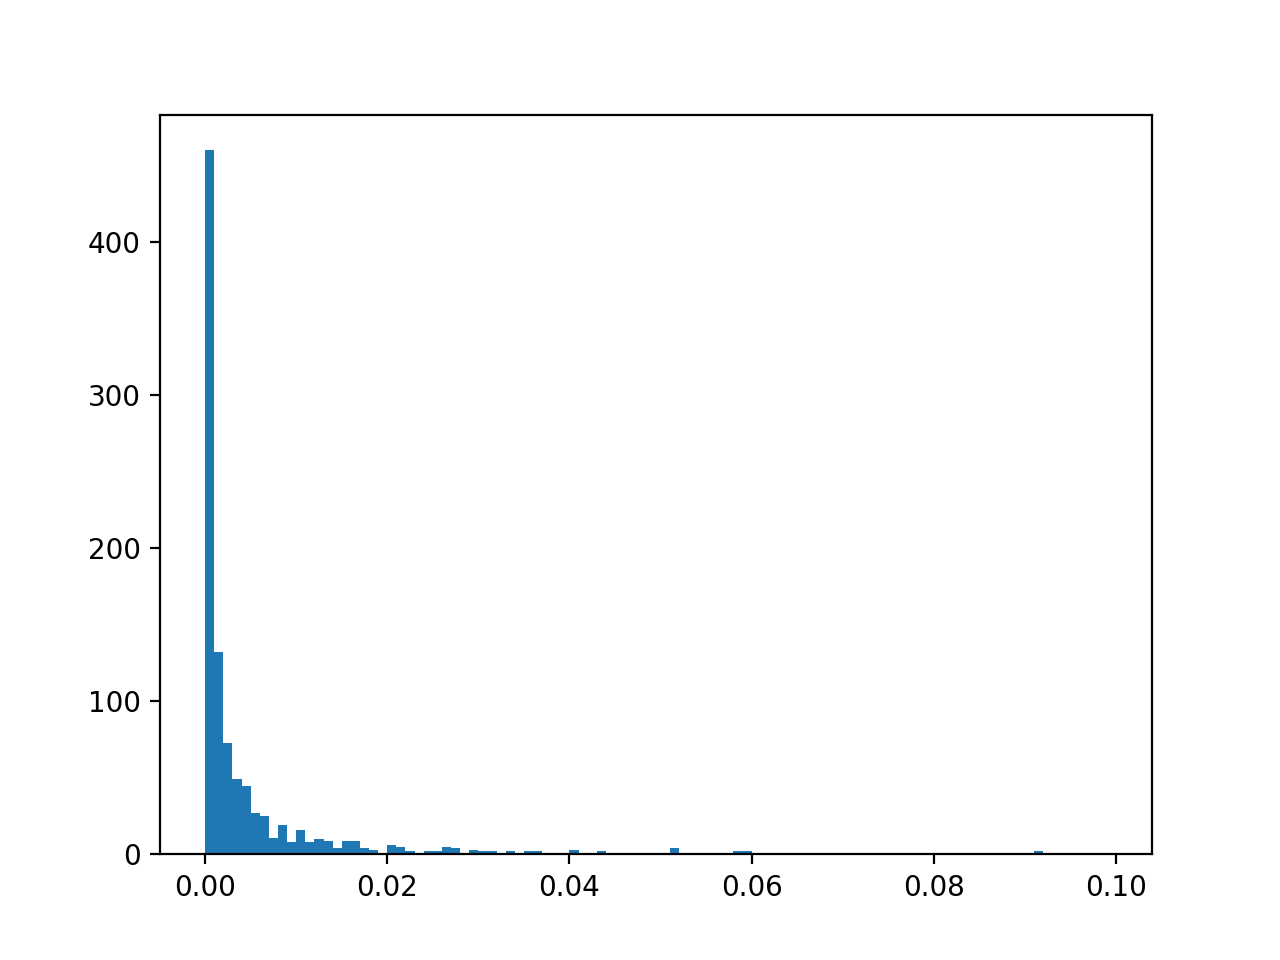

In [228]:
f,ax = plt.subplots(1,1)
ans=ax.hist(volumes,bins=np.arange(0,.1,.001))

In [41]:


subdir=os.path.splitext(os.path.split(mod.args['trakem2project'])[1])[0]
if not os.path.isdir(subdir):
    os.makedirs(subdir)
i=0
zipup=zip(volumes,json_output['area_lists'])
order = np.argsort(volumes)

for k in order:
    al = json_output['area_lists'][k]
    #if volumes[k]>.1:
    f,ax = plt.subplots(1,1,figsize=(14,14))
    #print bboxes[i]
    c = np.random.rand(3,1)
    for area in al['areas']:
        for path in area['paths']:
            poly = geometry.Polygon(path['orig_path'])
            x,y = poly.boundary.xy
            #print poly
            ax.plot(np.array(x),np.array(y)*-1,'r')
    #print volumes[i]
    ax.set_title(al['oid'])
    ax.set_xlim([-2600,2700])
    ax.set_ylim([-3000,1540])
    f.savefig(os.path.join(subdir,'%07d.png'%i))
    i+=1

In [31]:
np.sort()

In [159]:
np.array(x)

array([ 11.,  11.,  10.,  10.,   9.,   9.,   7.,   7.,   6.,   6.,   4.,
         4.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
         1.,   3.,   3.,   4.,   4.,   5.,   5.,   6.,   6.,   7.,   7.,
         8.,   8.,   9.,   9.,  11.,  11.,  12.,  12.,  13.,  13.,  14.,
        14.,  15.,  15.,  17.,  17.,  20.,  20.,  21.,  21.,  22.,  22.,
        23.,  23.,  24.,  24.,  25.,  25.,  25.,  26.,  26.,  27.,  27.,
        28.,  28.,  29.,  29.,  30.,  30.,  31.,  31.,  32.,  32.,  33.,
        33.,  34.,  34.,  35.,  35.,  37.,  37.,  39.,  39.,  51.,  51.,
        53.,  53.,  57.,  57.,  59.,  59.,  59.,  61.,  61.,  63.,  63.,
        65.,  65.,  67.,  67.,  69.,  69.,  69.,  71.,  71.,  77.,  77.,
        79.,  79.,  81.,  81.,  81.,  83.,  83.,  83.,  83.,  83.,  85.,
        85.,  85.,  85.,  85.,  85.,  85.,  85.,  85.,  87.,  87.,  89.,
        89.,  91.,  91.,  91.,  91.,  93.,  93.,  93.,  92.,  92.,  91.,
        91.,  90.,  90.,  77.,  77.,  76.,  76.,  4

In [150]:
al['oid']

'2778'

In [107]:
print volumes[volumes>1]
print np.sum(volumes>1)*1.0/len(volumes)

[]
0.0


In [108]:
np.max(volumes)

0.10284119999999999

In [95]:
print volumes[volumes>1]
print np.sum(volumes>1)*1.0/len(volumes)

[ 6.53147712  5.72178096  1.3706658 ]
0.00923076923077


In [71]:
from AnnotationJsonSchema import AnnotationFile


In [27]:
schema = AnnotationFile()
test = schema.dump(json_output)

In [28]:
example_local_annotation = 'local_annotation.json'
fp = open(example_local_annotation,'w')
json.dump(test.data,fp)
fp.close()

In [14]:
print ts.ip.get(0)
print ts.z
render_tspecs=mod.render.run(renderapi.tilespec.get_tile_specs_from_z,
                             mod.args['EMstack'],
                             ts.z)


{'imageUrl': u'file:/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/Site 3/S_046_936280491/Tile_r2-c2_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/trakem2.1474404253542.1123465259.478816230/trakem2.masks/41/9.518.zip'}
46.0


In [18]:
for ts in render_tspecs:
    print ts.ip.get(0)

{'imageUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c1_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c1_S_046_93628_mask.tif'}
{'imageUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r2-c2_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r2-c2_S_046_93628_mask.tif'}
{'imageUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c3_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c3_S_0

<IPython.core.display.Javascript object>


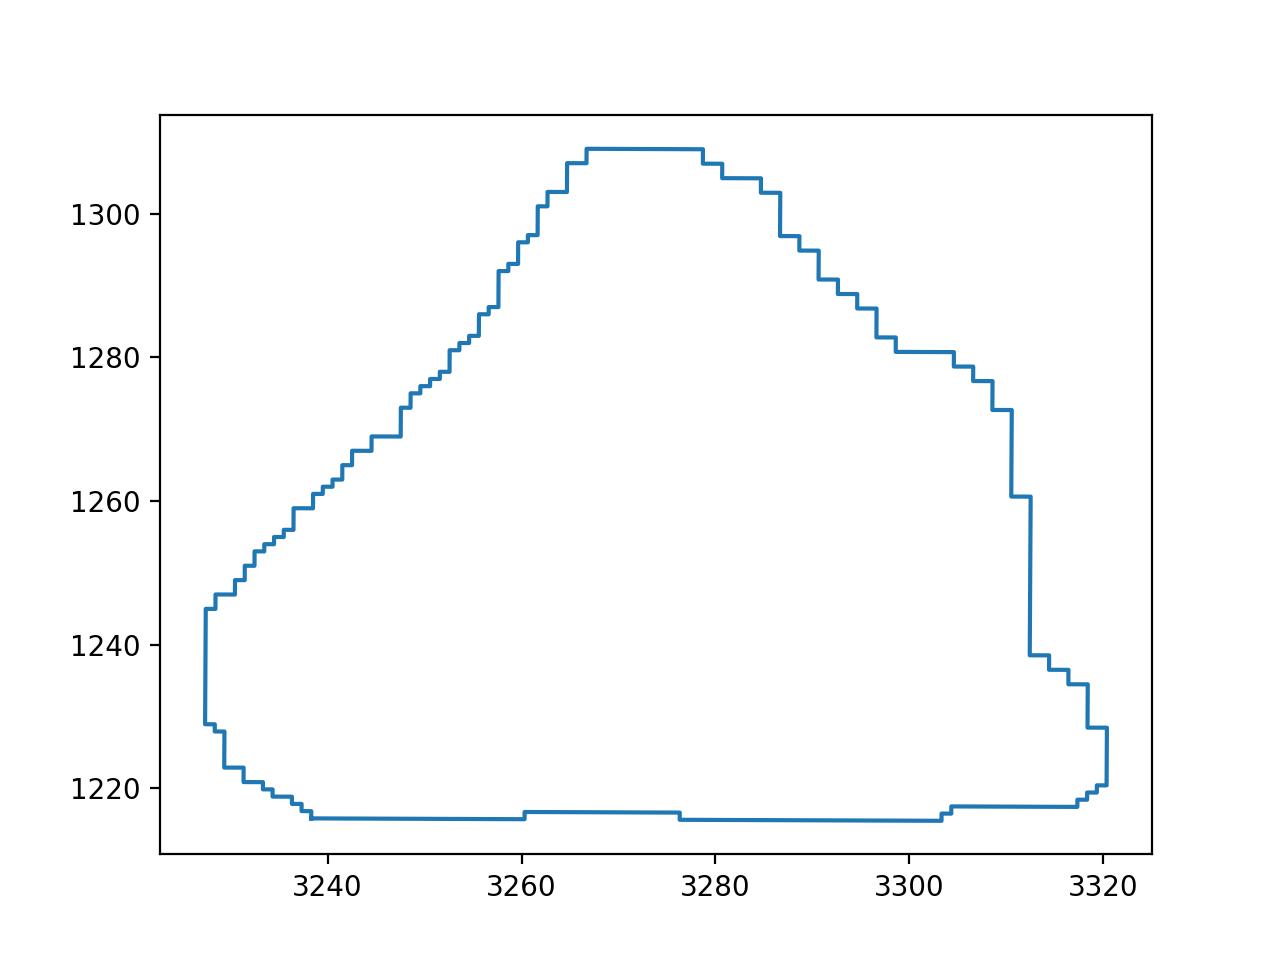

In [11]:
import matplotlib.pyplot as plt
plt.plot(local_path[:,0],local_path[:,1])


In [17]:
a=['a','b','c']
b=list(a)
a.reverse()
print a
print b

['c', 'b', 'a']
['a', 'b', 'c']


In [7]:
'ERROR' in 'ERROR IS HERE'

True

In [74]:
renderapi.tilespec.AffineModel.tform()

In [12]:
tform

M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-560.000000,-934.000000]

In [34]:
p2, Nd = tform.convert_to_point_vector(path)
pt = np.dot(np.linalg.inv(tile_tform.M), p2.T).T
print tform.convert_points_vector_to_array(pt, Nd)

[[ 3238.31965348  1215.78146328]
 [ 3238.32392414  1216.7859872 ]
 [ 3237.32418807  1216.79116012]
 [ 3237.32845874  1217.79568404]
 [ 3236.32872267  1217.80085697]
 [ 3236.33299333  1218.80538089]
 [ 3234.3335212   1218.81572673]
 [ 3234.33779186  1219.82025065]
 [ 3233.33805579  1219.82542358]
 [ 3233.34232645  1220.8299475 ]
 [ 3231.34285432  1220.84029335]
 [ 3231.35139564  1222.84934118]
 [ 3229.35192351  1222.85968703]
 [ 3229.37327682  1227.88230663]
 [ 3228.37354075  1227.88747955]
 [ 3228.37781141  1228.89200347]
 [ 3227.37807534  1228.8971764 ]
 [ 3227.40369931  1234.92431991]
 [ 3227.4165113   1237.93789167]
 [ 3227.43359395  1241.95598734]
 [ 3227.44640593  1244.9695591 ]
 [ 3228.446142    1244.96438617]
 [ 3228.45468333  1246.97343401]
 [ 3230.45415546  1246.96308816]
 [ 3230.46269679  1248.972136  ]
 [ 3231.46243285  1248.96696307]
 [ 3231.47097418  1250.97601091]
 [ 3232.47071024  1250.97083799]
 [ 3232.47925157  1252.97988582]
 [ 3233.47898764  1252.9747129 ]
 [ 3233.48

In [31]:
Nd

2

In [107]:
import tempfile